<a href="https://colab.research.google.com/github/keiiigo/RecursosOpenSource/blob/pyvrp/PyVRP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyvrp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from pyvrp import Model
import math
import matplotlib.pyplot as plt
from pyvrp.plotting import plot_coordinates
from pyvrp.stop import MaxRuntime
from pyvrp.plotting import plot_solution
from pyvrp.stop import MaxRuntime
import folium
import random

PyVRP v0.10.1

Solving an instance with:
    1 depot
    101 clients
    11 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best

Search terminated in 1.03s after 32 iterations.
Best-found solution has cost 3546430.

Solution results
    # routes: 7
   # clients: 101
   objective: 3546430
    distance: 3546430
    duration: 0
# iterations: 32
    run-time: 1.03 seconds

Solution results
    # routes: 7
   # clients: 101
   objective: 3546430
    distance: 3546430
    duration: 0
# iterations: 32
    run-time: 1.03 seconds

Routes
------
Route #1: 29 8 17 7 2 62 6 33 40 42 1 4 5 20 65 
Route #2: 59 51 75 61 23 35 24 25 71 22 98 3 9 90 53 
Route #3: 45 49 93 100 83 94 39 34 31 64 46 58 15 10 88 
Route #4: 52 44 66 82 79 28 85 32 96 99 38 89 26 54 80 
Route #5: 87 67 55 69 86 70 14 37 50 18 12 16 95 77 47 
Route #6: 60 56 57 11 84 101 48 27 76 63 30 13 21 41 72 
Route #7: 78 74 36 97 92 91 

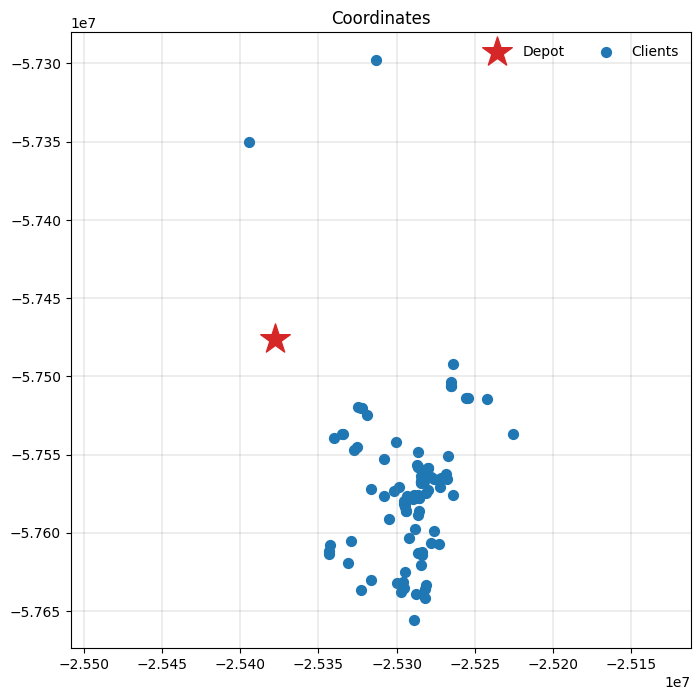

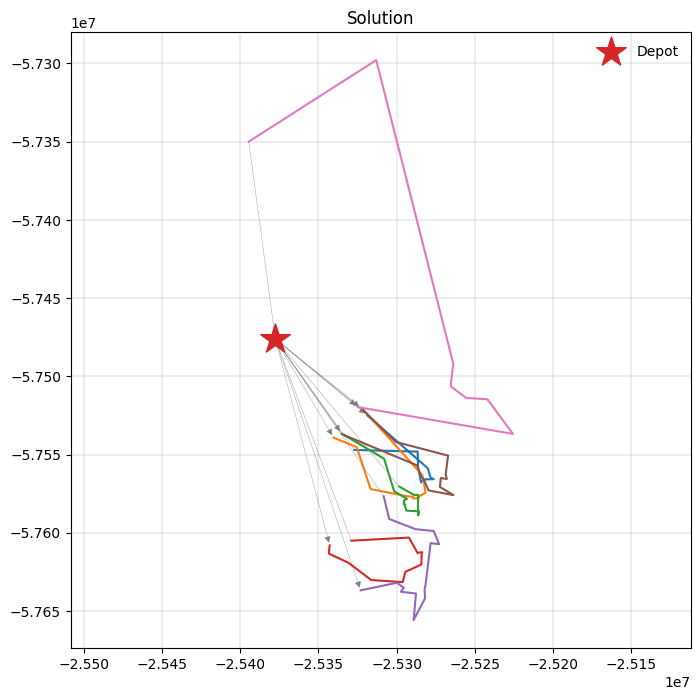

In [ ]:
#Leemos el pd
df = pd.read_csv('clientescor2.csv')
#Scaling_factor es utilizado para no tener decimales
scaling_factor = 1000000
#Convertimos latitud y longitud con scaling_factor
df['Latitude'] = (df['Latitude'] * scaling_factor).round().astype(int)
df['Longitude'] = (df['Longitude'] * scaling_factor).round().astype(int)
df['Demand'] = df['Demand'].astype(int)

COORDS = df[['Latitude', 'Longitude']].values
DEMANDS = df['Demand'].values
#Iniciamos el modelo de pyvrp
m = Model()
#Capacidad y cantidad de vehiculos
m.add_vehicle_type(11, capacity=15)

depot = m.add_depot(x=COORDS[0][0], y=COORDS[0][1])

clients = [
    m.add_client(x=COORDS[idx][0], y=COORDS[idx][1], delivery=[DEMANDS[idx]])
    for idx in range(1, len(COORDS))
]

locations = [depot] + clients
for frm in locations:
    for to in locations:
        distance = abs(frm.x - to.x) + abs(frm.y - to.y)
        m.add_edge(frm, to, distance=distance)

_, ax = plt.subplots(figsize=(8, 8))
plot_coordinates(m.data(), ax=ax)


res = m.solve(stop=MaxRuntime(1), display=True)

print(res)

_, ax = plt.subplots(figsize=(8, 8))
plot_solution(res.best, m.data(), ax=ax)


In [ ]:
def display_original(solution, df, scaling_factor=1000000):
    depot_coords = [df.loc[0, 'Latitude'], df.loc[0, 'Longitude']]
    depot_original_coords = (depot_coords[0] / scaling_factor, depot_coords[1] / scaling_factor)

    depot_id = df.loc[0, 'CustomerID']

    print(f"Depot (CustomerID: {depot_id}): {depot_original_coords}\n")

    for route_idx, route in enumerate(solution.best.routes(), start=1):
        route_client_indices = route.visits()[1:-1]
        route_customer_ids = [df.loc[idx, 'CustomerID'] for idx in route_client_indices]

        route_str = " -> ".join(map(str, [depot_id] + route_customer_ids + [depot_id]))
        print(f"Vehicle #{route_idx}: {route_str}")


In [ ]:
display_original(res, df)


Depot (CustomerID: 0): (-25.377562, -57.476188)

Vehicle #1: 0 -> 8 -> 17 -> 7 -> 2 -> 62 -> 6 -> 33 -> 40 -> 42 -> 1 -> 4 -> 5 -> 20 -> 0
Vehicle #2: 0 -> 51 -> 75 -> 61 -> 23 -> 35 -> 24 -> 25 -> 71 -> 22 -> 98 -> 3 -> 9 -> 90 -> 0
Vehicle #3: 0 -> 49 -> 93 -> 100 -> 83 -> 94 -> 39 -> 34 -> 31 -> 64 -> 46 -> 58 -> 15 -> 10 -> 0
Vehicle #4: 0 -> 44 -> 66 -> 82 -> 79 -> 28 -> 85 -> 32 -> 96 -> 99 -> 38 -> 89 -> 26 -> 54 -> 0
Vehicle #5: 0 -> 67 -> 55 -> 69 -> 86 -> 70 -> 14 -> 37 -> 50 -> 18 -> 12 -> 16 -> 95 -> 77 -> 0
Vehicle #6: 0 -> 56 -> 57 -> 11 -> 84 -> 101 -> 48 -> 27 -> 76 -> 63 -> 30 -> 13 -> 21 -> 41 -> 0
Vehicle #7: 0 -> 74 -> 36 -> 97 -> 92 -> 91 -> 73 -> 68 -> 81 -> 19 -> 0


In [ ]:
def display_solution(solution, df, scaling_factor=1000000):
    depot_coords = [
        df.loc[0, 'Latitude'] / scaling_factor,
        df.loc[0, 'Longitude'] / scaling_factor,
    ]

    folium_map = folium.Map(location=depot_coords, zoom_start=12)

    folium.Marker(
        location=depot_coords,
        popup="Depot",
        icon=folium.Icon(color="red", icon="home"),
    ).add_to(folium_map)

    colors = [
        "blue", "green", "purple", "orange", "darkred",
        "lightred", "beige", "darkblue", "darkgreen",
        "cadetblue", "darkpurple", "pink", "lightblue",
        "lightgreen", "gray", "black",
    ]
    random.shuffle(colors)

    for route_idx, route in enumerate(solution.best.routes(), start=1):
        route_client_indices = route.visits()[1:-1]
        route_coords_original = [
            (
                df.loc[client_idx, "Latitude"] / scaling_factor,
                df.loc[client_idx, "Longitude"] / scaling_factor,
            )
            for client_idx in route_client_indices
        ]

        route_color = colors[route_idx % len(colors)]
        folium.PolyLine(
            locations=[depot_coords] + route_coords_original + [depot_coords],
            color=route_color,
            weight=4,
            opacity=0.8,
            popup=f"Route #{route_idx}",
        ).add_to(folium_map)

        for client_idx, client_coords in zip(route_client_indices, route_coords_original):
            folium.Marker(
                location=client_coords,
                popup=f"Client #{client_idx}",
                icon=folium.Icon(color=route_color),
            ).add_to(folium_map)

    return folium_map


In [ ]:
folium_map = display_solution(res, df, scaling_factor)

folium_map